<a href="https://colab.research.google.com/github/Aditya17-bot/Fraud_detection/blob/main/fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = (14, 8)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


In [2]:
train_path = 'fraudTrain.csv'
test_path  = 'fraudTest.csv'

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
train_df.head()


Train shape: (1296675, 23)
Test shape : (555719, 23)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
import pandas as pd

# 1) Handle datetime feature extraction first
def process_datetime_features(df):
    if 'trans_date_trans_time' in df.columns:
        dt = pd.to_datetime(df['trans_date_trans_time'], errors='coerce')
        df = df.copy()
        df['trans_hour'] = dt.dt.hour
        df['trans_dow'] = dt.dt.dayofweek  # 0=Monday, 6=Sunday
        df['trans_month'] = dt.dt.month
        df = df.drop(columns=['trans_date_trans_time'])
    return df

# Apply datetime processing
train_df_processed = process_datetime_features(train_df)
test_df_processed = process_datetime_features(test_df)

# 2) Define columns (add more useful features)
categorical_cols = ['merchant', 'category', 'gender', 'city', 'state', 'job']
numeric_cols = ['amt', 'zip', 'lat', 'long', 'city_pop']

# Add time features if they exist
if 'trans_hour' in train_df_processed.columns:
    numeric_cols.extend(['trans_hour', 'trans_dow', 'trans_month'])

# 3) Build preprocessing pipeline
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
    ('num', MinMaxScaler(), numeric_cols)  # scales to [0,1]
], remainder='drop')  # automatically drops cc_num, first, last, street, dob

# 4) Select and process features
X_train = train_df_processed[categorical_cols + numeric_cols]
X_test = test_df_processed[categorical_cols + numeric_cols]

X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = preprocess.transform(X_test)

print("Original train shape:", X_train.shape)
print("Processed train shape:", X_train_processed.shape)
print("Processed test shape:", X_test_processed.shape)


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Original train shape: (1296675, 14)
Processed train shape: (1296675, 2150)
Processed test shape: (555719, 2150)


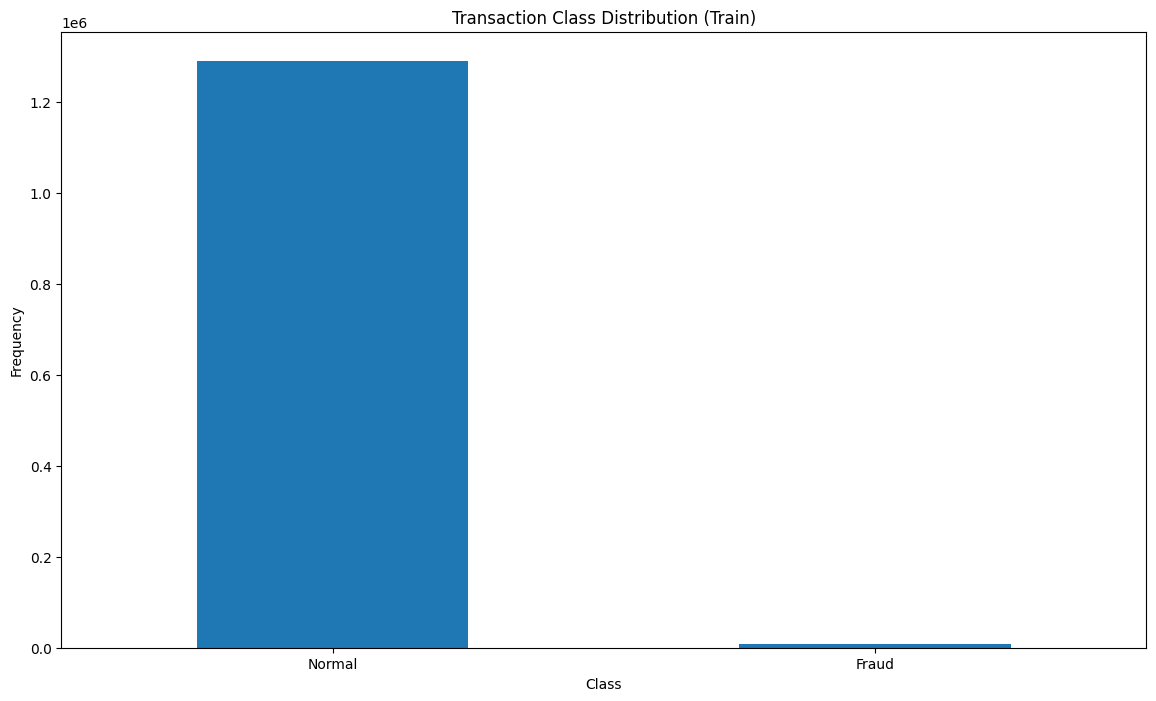

Fraud, Normal shapes: (7506, 23) (1289169, 23)


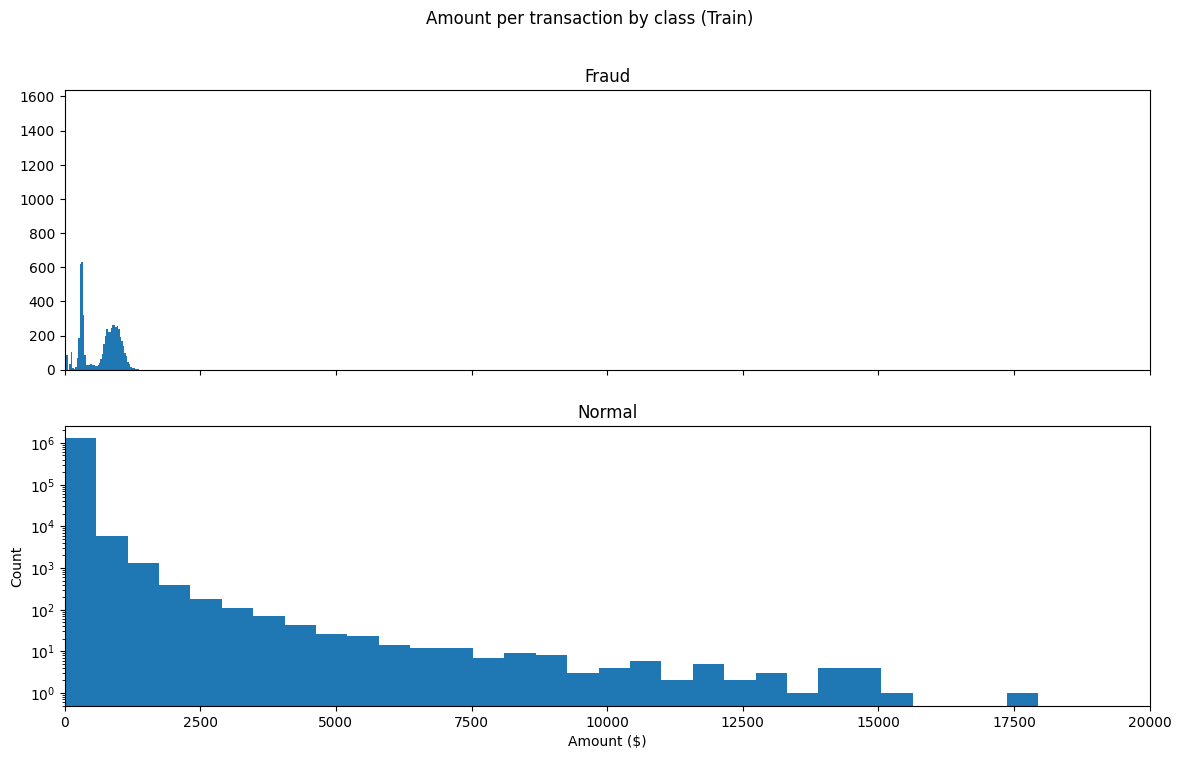

In [4]:
LABELS = ["Normal", "Fraud"]

ax = train_df['is_fraud'].value_counts().sort_index().plot(kind='bar', rot=0)
ax.set_title("Transaction Class Distribution (Train)")
ax.set_xlabel("Class")
ax.set_ylabel("Frequency")
ax.set_xticklabels(LABELS)
plt.show()

fraud = train_df[train_df['is_fraud'] == 1]
normal = train_df[train_df['is_fraud'] == 0]
print("Fraud, Normal shapes:", fraud.shape, normal.shape)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Amount per transaction by class (Train)')
bins = 50
ax1.hist(fraud['amt'], bins=bins); ax1.set_title('Fraud')
ax2.hist(normal['amt'], bins=bins); ax2.set_title('Normal')
plt.xlabel('Amount ($)'); plt.ylabel('Count'); plt.yscale('log'); plt.xlim((0, 20000))
plt.show()


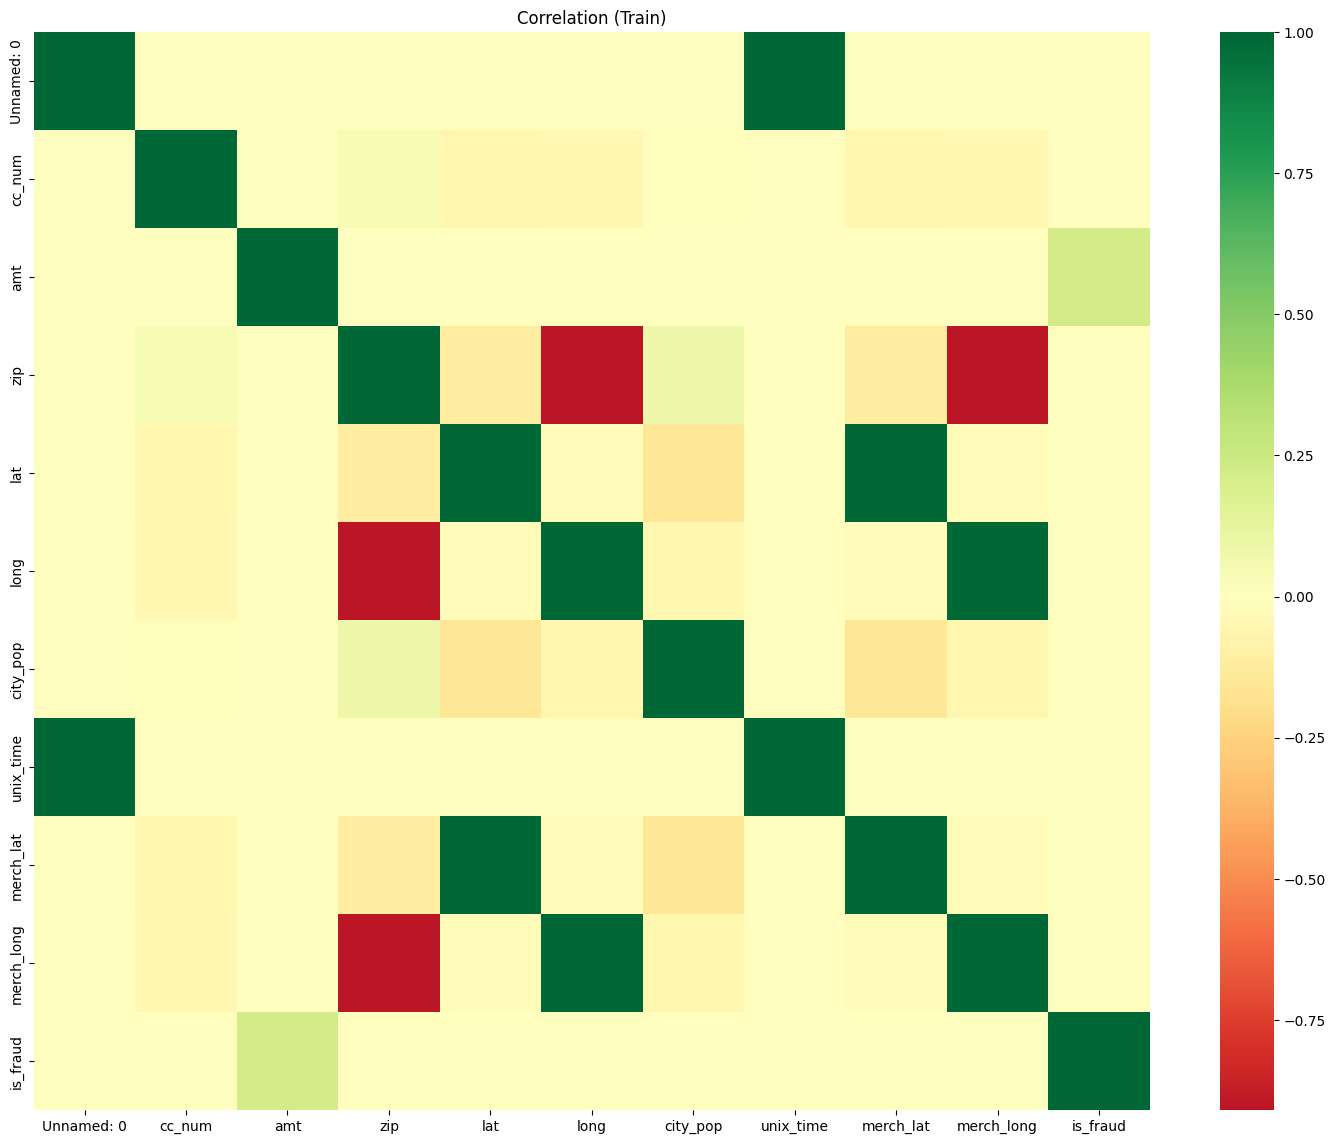

Train features/labels: (1296675, 22) (1296675,)
Test  features/labels: (555719, 22) (555719,)


In [5]:
target_col = 'is_fraud'  # Changed from 'Class' to 'is_fraud'
feature_cols = [c for c in train_df.columns if c != target_col]

X_train_raw = train_df[feature_cols]
y_train = train_df[target_col].astype(int)

X_test_raw = test_df[feature_cols]
y_test = test_df[target_col].astype(int)

corr = train_df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(18, 14))
sns.heatmap(corr, cmap='RdYlGn', center=0)
plt.title('Correlation (Train)')
plt.show()

print("Train features/labels:", X_train_raw.shape, y_train.shape)
print("Test  features/labels:", X_test_raw.shape, y_test.shape)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_processed, y_train)

print("Balanced train shapes:", X_train_bal.shape, y_train_bal.shape)
print("Balanced class counts:", np.bincount(y_train_bal))



Balanced train shapes: (2578338, 2150) (2578338,)
Balanced class counts: [1289169 1289169]


In [13]:
from sklearn.model_selection import train_test_split

# Create validation split from your training data
X_train_split, X_val_processed, y_train_split, y_val = train_test_split(
    X_train_processed,
    y_train,
    test_size=0.2,  # 20% for validation
    random_state=42,
    stratify=y_train  # Maintain class balance in both splits
)

print("Original training shape:", X_train_processed.shape, y_train.shape)
print("New training shape:", X_train_split.shape, y_train_split.shape)
print("Validation shape:", X_val_processed.shape, y_val.shape)
print("Validation fraud ratio:", y_val.mean())


Original training shape: (1296675, 2150) (1296675,)
New training shape: (1037340, 2150) (1037340,)
Validation shape: (259335, 2150) (259335,)
Validation fraud ratio: 0.005787880540613492


In [14]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve

# 1) Train BRF with reduced complexity for speed
brf = BalancedRandomForestClassifier(
    n_estimators=150,        # Reduced from 300 (50% fewer trees)
    max_depth=15,            # Limit tree depth to prevent overfitting
    min_samples_split=20,    # Faster splits with larger minimum
    min_samples_leaf=10,     # Larger leaf nodes = faster training
    random_state=42,
    n_jobs=-1
)
brf.fit(X_train_processed, y_train)

# 2) Faster calibration with sigmoid method and fewer folds
cal = CalibratedClassifierCV(
    brf,
    cv=3,                    # Reduced from 5 folds
    method='sigmoid'         # Faster than isotonic for large datasets
)
cal.fit(X_train_processed, y_train)

# 3) Threshold selection on validation data
val_probs = cal.predict_proba(X_val_processed)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_probs)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = f1.argmax()
best_thr = thr[best_idx] if best_idx < len(thr) else 1.0

print(f"Best threshold: {best_thr:.3f}")
print(f"Best F1 score: {f1[best_idx]:.3f}")

# 4) Apply to test
test_probs = cal.predict_proba(X_test_processed)[:, 1]
y_pred_test = (test_probs >= best_thr).astype(int)



Best threshold: 0.283
Best F1 score: 0.604


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# Detailed performance metrics
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(cm)
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_test, digits=3))

# Calculate individual metrics
tp, fn, fp, tn = cm[1,1], cm[1,0], cm[0,1], cm[0,0]
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nKey Metrics at threshold {best_thr:.3f}:")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1[best_idx]:.3f}")


Confusion Matrix:
[[552833    741]
 [  1302    843]]

Classification Report:
              precision    recall  f1-score   support

           0      0.998     0.999     0.998    553574
           1      0.532     0.393     0.452      2145

    accuracy                          0.996    555719
   macro avg      0.765     0.696     0.725    555719
weighted avg      0.996     0.996     0.996    555719


Key Metrics at threshold 0.283:
Precision: 0.532
Recall: 0.393
F1 Score: 0.604


In [17]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate scale_pos_weight for imbalanced data
fraud_ratio = sum(y_train) / len(y_train)
scale_pos_weight = (1 - fraud_ratio) / fraud_ratio  # Ratio of negative to positive
print(f"Fraud ratio: {fraud_ratio:.4f}")
print(f"Scale_pos_weight: {scale_pos_weight:.2f}")

# 1) Train XGBoost with imbalanced data handling
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

# Fit XGBoost
print("Training XGBoost...")
xgb_model.fit(X_train_processed, y_train)

# 2) Get XGBoost predictions and probabilities
xgb_pred = xgb_model.predict(X_test_processed)
xgb_proba = xgb_model.predict_proba(X_test_processed)[:, 1]

# Evaluate XGBoost alone
print("\n=== XGBoost Performance ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_pred))
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred, digits=3))


Fraud ratio: 0.0058
Scale_pos_weight: 171.75
Training XGBoost...

=== XGBoost Performance ===
Confusion Matrix:
[[545462   8112]
 [   136   2009]]

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.985     0.992    553574
           1      0.198     0.937     0.328      2145

    accuracy                          0.985    555719
   macro avg      0.599     0.961     0.660    555719
weighted avg      0.997     0.985     0.990    555719



In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_recall_curve

# Create ensemble using your EXISTING models
# Note: Using 'brf' (your calibrated model from earlier) instead of creating new one
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),      # Your already trained XGBoost
        ('brf', brf)             # Your existing BalancedRandomForest from calibration
    ],
    voting='soft',  # Use probability averaging for better calibration
    n_jobs=-1
)

print("Training Ensemble (XGBoost + Existing BalancedRandomForest)...")
ensemble.fit(X_train_processed, y_train)

# Get ensemble probabilities
ensemble_proba = ensemble.predict_proba(X_test_processed)[:, 1]

# Find optimal threshold for ensemble
prec, rec, thr = precision_recall_curve(y_test, ensemble_proba)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = f1_scores.argmax()
best_threshold = thr[best_idx] if best_idx < len(thr) else 1.0

print(f"\nBest ensemble threshold: {best_threshold:.3f}")
print(f"Best ensemble F1 score: {f1_scores[best_idx]:.3f}")

# Apply optimal threshold
ensemble_pred = (ensemble_proba >= best_threshold).astype(int)

# Compare all three models
models = {
    'XGBoost': (xgb_pred, xgb_proba),
    'BalancedRandomForest': (y_pred_test, test_probs),  # From your earlier calibrated model
    'Ensemble': (ensemble_pred, ensemble_proba)
}

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

for name, (pred, proba) in models.items():
    cm = confusion_matrix(y_test, pred)
    tp, fn, fp, tn = cm[1,1], cm[1,0], cm[0,1], cm[0,0]

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{name}:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1 Score: {f1:.3f}")
    print(f"  True Positives: {tp}")
    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")


Training Ensemble (XGBoost + Existing BalancedRandomForest)...

Best ensemble threshold: 0.801
Best ensemble F1 score: 0.644

MODEL COMPARISON

XGBoost:
  Precision: 0.198
  Recall: 0.937
  F1 Score: 0.328
  True Positives: 2009
  False Positives: 8112
  False Negatives: 136

BalancedRandomForest:
  Precision: 0.532
  Recall: 0.393
  F1 Score: 0.452
  True Positives: 843
  False Positives: 741
  False Negatives: 1302

Ensemble:
  Precision: 0.742
  Recall: 0.569
  F1 Score: 0.644
  True Positives: 1220
  False Positives: 425
  False Negatives: 925
